<a href="https://imgur.com/AmexJRq"><img src="https://i.imgur.com/AmexJRq.png" style="float: left; margin: 15px; height: 80px" title="source: imgur.com" /></a>
## Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import patsy
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from math import log, exp, sqrt

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<a href="https://imgur.com/oUz4xal"><img src="https://i.imgur.com/oUz4xal.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px" title="source: imgur.com" /></a>

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')

In [3]:
# Load data text
file = open('data_description.txt','r') 
 
# print file.read()

##### 1.1 Check shape, head and info of house data
---

In [4]:
shape = house.shape
shape

(1460, 81)

In [5]:
# inspect head by ensuring that all columns are displayed
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

In [6]:
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [8]:
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [10]:
# Understand the unique values of each columns
house.nunique().sort_values()

CentralAir          2
Utilities           2
Street              2
Alley               2
BsmtHalfBath        3
LandSlope           3
GarageFinish        3
HalfBath            3
PavedDrive          3
PoolQC              3
FullBath            4
MasVnrType          4
BsmtExposure        4
ExterQual           4
MiscFeature         4
BsmtFullBath        4
Fence               4
KitchenQual         4
BsmtCond            4
Fireplaces          4
LandContour         4
LotShape            4
KitchenAbvGr        4
BsmtQual            4
FireplaceQu         5
Electrical          5
YrSold              5
GarageCars          5
GarageQual          5
GarageCond          5
HeatingQC           5
ExterCond           5
MSZoning            5
LotConfig           5
BldgType            5
BsmtFinType2        6
Foundation          6
RoofStyle           6
SaleCondition       6
GarageType          6
BsmtFinType1        6
Heating             6
Functional          7
RoofMatl            8
HouseStyle          8
Condition2

#### 1.2 Remove rows where MSZoning is non-residential i.e. A, C or I
---

In [291]:
#Understand the different zoning in the dataset
house['MSZoning'].value_counts()

# The dataset includes commercial properties which is not necessary

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [292]:
# Remove non-residential
house = house[house.MSZoning != 'C (all)']
house.shape
# note: we lost 10 rows. 


(1450, 81)

#### 1.3 Inspect null values. Drop ID & columns with more than 40% null values
---

In [11]:
house.isnull().sum().sort_values(ascending= False).head(10)
# PoolQC, MiscFeature, Alley, Fence,
#FireplaceQu & LotFrontage have a lot of null values      


PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageCond        81
GarageType        81
GarageYrBlt       81
GarageFinish      81
dtype: int64

In [12]:
#drop irrelavant columns for modelling
house.drop('Id', axis=1, inplace=True)


In [13]:
#look for columns with more than 40% null values
null_cols = house.columns[house.isnull().sum()> len(house)*0.4]
null_cols

Index(['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], dtype='object')

In [14]:
#drop columns with more than 40% null values
house.drop(null_cols, axis=1, inplace=True)

#### 1.4 Assess the remainding null values
---

In [15]:
house.isnull().sum().sort_values(ascending= False).head(10)

LotFrontage     259
GarageType       81
GarageYrBlt      81
GarageCond       81
GarageQual       81
GarageFinish     81
BsmtExposure     38
BsmtFinType2     38
BsmtFinType1     37
BsmtCond         37
dtype: int64

<a href="https://imgur.com/aAMgLKD"><img src="https://i.imgur.com/aAMgLKD.png" style="float: left; margin: 20px; height: 100px" title="source: imgur.com" /></a>

---
Since the data cannot be further reduce as it would be too short, we need to fill in the null values

#### 1.5 Fill in null values
---

In [16]:
isnull = pd.DataFrame(house.isnull().sum(), columns=['null_values']).reset_index()
isnull = isnull[isnull['null_values'] != 0]
isnull

,index,null_values
2,LotFrontage,259
23,MasVnrType,8
24,MasVnrArea,8
28,BsmtQual,37
29,BsmtCond,37
30,BsmtExposure,38
31,BsmtFinType1,37
33,BsmtFinType2,38
40,Electrical,1
55,GarageType,81


#### 1.6 Fill numerical data with median & categorical data with median or mode values
---

In [18]:
for col in isnull['index']:
    try:
        house[col].fillna(house[col].median(), inplace= True)
    except:
        house[col].fillna(house[col].mode()[0], inplace=True)
#Check if all the null values are being filled up
house.isnull().sum()

MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinSF1       0
BsmtFinType2     0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
KitchenQual      0
TotRmsAbvGrd

#### 1.7 Rename columns names with numbers as first character to facilitate patsy later on
---

In [19]:
number = {0:'zero', 1: 'one', 2:'two', 3: 'three', 4: 'four', 5: 'five', 6: 'six', 7:'seven', 8: 'eight', 9: 'nine'}

new_col_names= []

for col in house.columns:
    if col[0] in [str(x) for x in range(10)]:
        new_col = number[float(col[0])] + '_' + col[1:]
        new_col_names.append(new_col)
    else:
        new_col_names.append(col)
        
house.columns = new_col_names
        

#### 1.8 Find and handle outliers
---

In [20]:
house.describe(include='all')

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,one_stFlrSF,two_ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,three_SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
count,1460.000000,1460,1460.000000,1460.000000,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460.000000,1460.000000,1460.000000,1460.000000,1460,1460,1460,1460,1460,1460.000000,1460,1460,1460,1460,1460,1460,1460,1460.000000,1460,1460.000000,1460.000000,1460.000000,1460,1460,1460,1460,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460,1460.000000,1460,1460.000000,1460,1460.000000,1460,1460.000000,1460.000000,1460,1460,1460,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460,1460,1460.000000
unique,NaN,5,NaN,NaN,2,4,4,2,5,3,25,9,8,5,8,NaN,NaN,NaN,NaN,6,8,15,16,4,NaN,4,5,6,4,4,4,6,NaN,6,NaN,NaN,NaN,6,5,2,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,7,NaN,6,NaN,3,NaN,NaN,5,5,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,6,NaN
top,NaN,RL,NaN,NaN,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,NaN,NaN,NaN,NaN,Gable,CompShg,VinylSd,VinylSd,None,NaN,TA,TA,PConc,TA,TA,No,Unf,NaN,Unf,NaN,NaN,NaN,GasA,Ex,Y,SBrkr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TA,NaN,Typ,NaN,Attchd,NaN,Unf,NaN,NaN,TA,TA,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WD,Normal,NaN
freq,NaN,1151,NaN,NaN,1454,925,1311,1459,1052,1382,225,1260,1445,1220,726,NaN,NaN,NaN,NaN,1141,1434,515,504,872,NaN,906,1282,647,686,1348,991,467,NaN,1294,NaN,NaN,NaN,1428,741,1365,1335,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,735,NaN,1360,NaN,951,NaN,686,NaN,NaN,1392,1407,1340,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1267,1198,NaN
mean,56.897260,NaN,69.863699,10516.828082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.099315,5.575342,1971.267808,1984.865753,NaN,NaN,NaN,NaN,NaN,103.117123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,443.639726,NaN,46.549315,567.240411,1057.429452,NaN,NaN,NaN,NaN,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,NaN,6.517808,NaN,0.613014,NaN,1978.589041,NaN,1.767123,472.980137,NaN,NaN,NaN,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,NaN,NaN,180921.195890
std,42.300571,NaN,22.027677,9981.264932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.382997,1.112799,30.202904,20.645407,NaN,NaN,NaN,NaN,NaN,180.731373,NaN,NaN,NaN,NaN,NaN,NaN,NaN,456.098091,NaN,161.319273,441.866955,438.705324,NaN,NaN,NaN,NaN,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,NaN,1.625393,NaN,0.644666,NaN,23.997022,NaN,0.747315,213.804841,NaN,NaN,NaN,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,NaN,NaN,79442.502883
min,20.000000,NaN,21.000000,1300.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1872.000000,1950.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,2.000000,NaN,0.000000,NaN,1900.000000,NaN,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,NaN,NaN,34900.000000
25%,20.000000,NaN,60.000000,7553.500000,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [21]:
# Found that houses with 'LotArea' < or > 6 std away from mean

threshold = 6 * house['LotArea'].std()
lotarea_mask = abs( house['LotArea'] - house['LotArea'].mean() ) > threshold
house[lotarea_mask]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,one_stFlrSF,two_ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,three_SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
249,50,RL,69.0,159000,Pave,IR2,Low,AllPub,CulDSac,Sev,ClearCr,Norm,Norm,1Fam,1.5Fin,6,7,1958,2006,Gable,CompShg,Wd Sdng,HdBoard,BrkCmn,472.0,Gd,TA,CBlock,Gd,TA,Gd,Rec,697,Unf,0,747,1444,GasA,Gd,Y,SBrkr,1444,700,0,2144,0,1,2,0,4,1,Gd,7,Typ,2,Attchd,1958.0,Fin,2,389,TA,TA,Y,0,98,0,0,0,0,500,6,2007,WD,Normal,277000
313,20,RL,150.0,215245,Pave,IR3,Low,AllPub,Inside,Sev,Timber,Norm,Norm,1Fam,1Story,7,5,1965,1965,Hip,CompShg,BrkFace,BrkFace,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,1236,Rec,820,80,2136,GasW,TA,Y,SBrkr,2036,0,0,2036,2,0,2,0,3,1,TA,8,Typ,2,Attchd,1965.0,RFn,2,513,TA,TA,Y,0,0,0,0,0,0,0,6,2009,WD,Normal,375000
335,190,RL,69.0,164660,Grvl,IR1,HLS,AllPub,Corner,Sev,Timber,Norm,Norm,2fmCon,1.5Fin,5,6,1965,1965,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,TA,TA,Gd,ALQ,1249,BLQ,147,103,1499,GasA,Ex,Y,SBrkr,1619,167,0,1786,2,0,2,0,3,1,TA,7,Typ,2,Attchd,1965.0,Fin,2,529,TA,TA,Y,670,0,0,0,0,0,700,8,2008,WD,Normal,228950
451,20,RL,62.0,70761,Pave,IR1,Low,AllPub,Inside,Mod,ClearCr,Norm,Norm,1Fam,1Story,7,5,1975,1975,Gable,WdShngl,Plywood,Plywood,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,655,Unf,0,878,1533,GasA,TA,Y,SBrkr,1533,0,0,1533,1,0,2,0,2,1,Gd,5,Typ,2,Attchd,1975.0,Unf,2,576,TA,TA,Y,200,54,0,0,0,0,0,12,2006,WD,Normal,280000
706,20,RL,69.0,115149,Pave,IR2,Low,AllPub,CulDSac,Sev,ClearCr,Norm,Norm,1Fam,1Story,7,5,1971,2002,Gable,CompShg,Plywood,Plywood,Stone,351.0,TA,TA,CBlock,Gd,TA,Gd,GLQ,1219,Unf,0,424,1643,GasA,TA,Y,SBrkr,1824,0,0,1824,1,0,2,0,2,1,Gd,5,Typ,2,Attchd,1971.0,Unf,2,739,TA,TA,Y,380,48,0,0,0,0,0,6,2007,WD,Normal,302000


In [22]:
# create new column for big houses

house['big_house'] = 0
house.loc[lotarea_mask, 'big_house'] = 1
house['big_house'].value_counts()

0    1455
1       5
Name: big_house, dtype: int64

#### 1.9 Select relevant columns for analysis
---

In [23]:
""""Build a reliable estimator for the price of the house given characteristics of the house that 
CANNOT be renovated"""


# Remove non-fixed variables such as Exterior1st, Exterior2nd, ExterQual,ExterCond,BsmtQual, BsmtCond, 
# BsmtFinType1, BsmtFinType2, HeatingQC etc
# 'CentralAir' and 'Heating' cannot be changed
# 'BsmtExposure' will be a fixed variable as the exposure cannot be changed
# Target= SalePrice 



non_fixed = ['OverallQual','OverallCond','YearRemodAdd','RoofStyle','RoofMatl','Exterior1st','Exterior2nd',
             'MasVnrType','MasVnrArea','ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtFinType1','BsmtFinSF1',
             'BsmtFinType2','BsmtFinSF2','BsmtUnfSF','HeatingQC','Electrical','LowQualFinSF','KitchenQual',
             'Functional','GarageFinish','GarageQual','GarageCond','PavedDrive','MiscVal','SaleType','SaleCondition',
            'MoSold']

house_new = house.drop(non_fixed, axis=1)

In [24]:
#Checking the shape of the data
house_new.shape

(1460, 45)

#### 1.10 Explore relationships between SalePrice and other variables
---

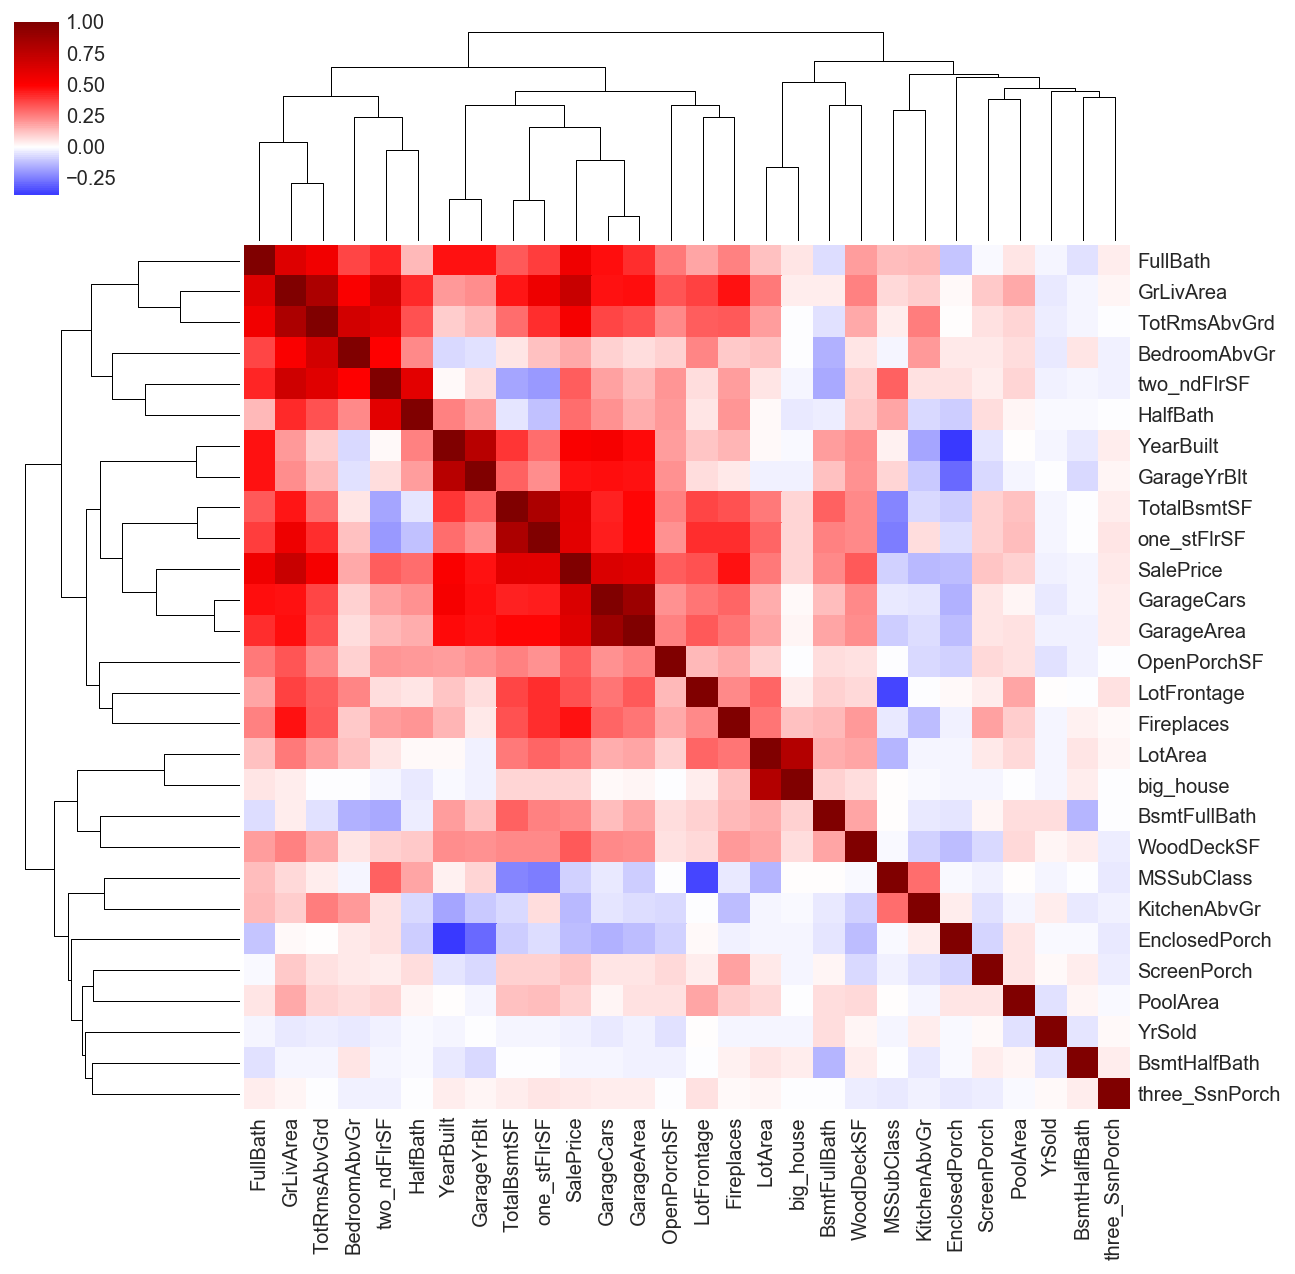

In [25]:
plt.figure(figsize=(14,14))
sns.clustermap(house_new.corr(), cmap='seismic', center=0)

In [26]:
abs(house_new.corr()['SalePrice']).sort_values(ascending=False).head(10)

SalePrice       1.000000
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
one_stFlrSF     0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Fireplaces      0.466929
Name: SalePrice, dtype: float64

#### 1.11 Model: train-test-split, scale, fit,predict using Lasso
---

In [27]:
target = 'SalePrice'

In [30]:

# create X, y
f = 'SalePrice ~ ' +  ' + '.join([c for c in house_new.columns])+' - 1'.format()
f

y, X = patsy.dmatrices(f, data=house_new, return_type='dataframe')

# create train (before 2010) test (2010) split
X_train = X[X['YrSold'] != 2010].drop([target,'YrSold'],axis=1)
y_train = X[X['YrSold'] != 2010][target]

X_test = X[X['YrSold'] == 2010].drop([target,'YrSold'],axis=1)
y_test = X[X['YrSold'] == 2010][target]


# scale
ss = StandardScaler()
ss.fit(X_train)
Xs_train = ss.transform(X_train)
Xs_test = ss.transform(X_test)


# fit and score
model_lasso = LassoCV(cv=10)
model_lasso.fit(Xs_train, y_train)
score = model_lasso.score(Xs_test, y_test)
y_pred_lasso = model_lasso.predict(Xs_test)
coefs = model_lasso.coef_
print(score)

0.8605892616213779


#### 1.12 Plot residuals
---

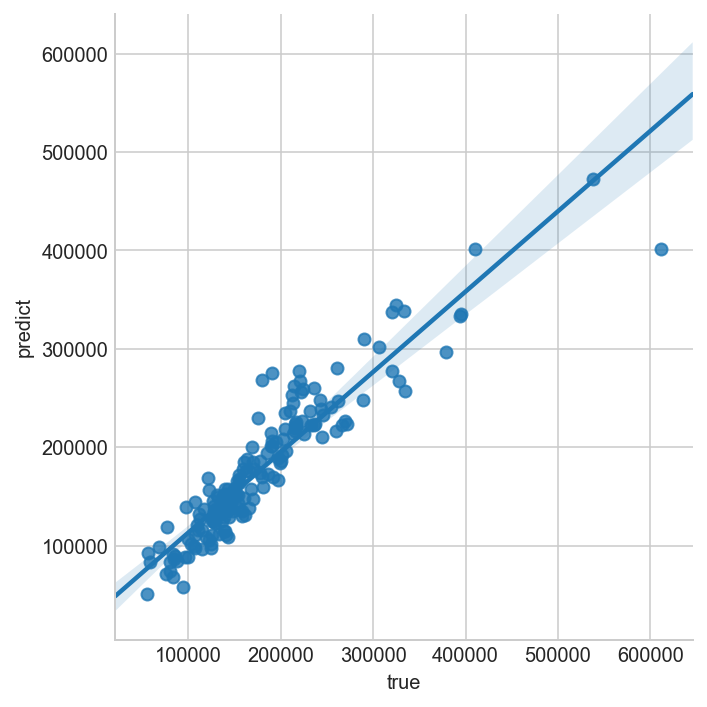

In [31]:
residual_plot = pd.DataFrame(list(zip(y_pred_lasso,y_test)), columns=['predict','true'])
sns.lmplot(x= 'true', y='predict', data=residual_plot)

In [32]:
residual_plot.head()

,predict,true
0,153968.943858,149000.0
1,151241.501279,154000.0
2,132550.282833,134800.0
3,301865.495610,306000.0
4,175591.208878,165500.0


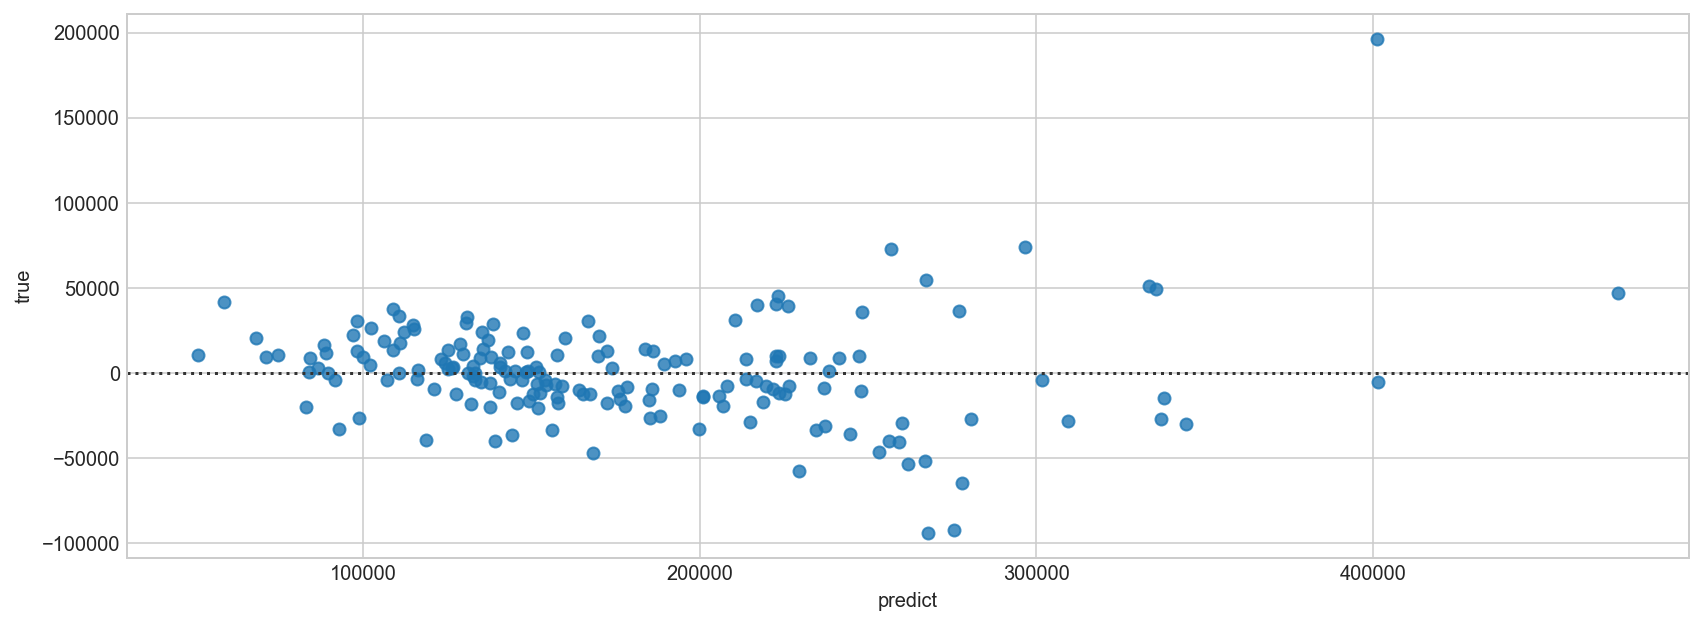

In [33]:
plt.figure(figsize=(14,5))
sns.residplot(x= 'predict', y='true', data=residual_plot)

<a href="https://imgur.com/aAMgLKD"><img src="https://i.imgur.com/aAMgLKD.png" style="float: left; margin: 20px; height: 100px" title="source: imgur.com" /></a>

---
As the residuals diverges as the prices increase, a linear regression is not appropriate. Therefore, we will use logarithmic model.

#### 1.13 Applying log function on the SalePrice
---

In [34]:
# add the log of the saleprice as a new column and drop the original saleprice
house['SalePrice_lg'] = house['SalePrice'].map(log)
non_fixed.append('SalePrice')
house_new_2 = house.drop(non_fixed, axis=1)

In [36]:
#Evaluate the score of the 'SalePrice_lg
# create X, y
f = 'SalePrice_lg ~ ' +  ' + '.join([c for c in house_new_2.columns])+' - 1'.format()

y, X_log = patsy.dmatrices(f, data=house_new_2, return_type='dataframe')

# create train (before 2010) test (2010) split
X_train_log = X_log[X_log['YrSold'] != 2010].drop(['SalePrice_lg','YrSold'],axis=1)
y_train_log = X_log[X_log['YrSold'] != 2010]['SalePrice_lg']

X_test_log = X_log[X_log['YrSold'] == 2010].drop(['SalePrice_lg','YrSold'],axis=1)
y_test_log = X_log[X_log['YrSold'] == 2010]['SalePrice_lg']


# scale
ss = StandardScaler()
ss.fit(X_train_log)
Xs_train_log = ss.transform(X_train_log)
Xs_test_log = ss.transform(X_test_log)


# fit and score
model_lasso_log = LassoCV(cv=10)
model_lasso_log.fit(Xs_train_log, y_train_log)
score_log = model_lasso_log.score(Xs_test_log, y_test_log)
y_pred_lasso_log = model_lasso.predict(Xs_test_log)
coefs_log = model_lasso_log.coef_
print(score_log)

0.8973966456429032


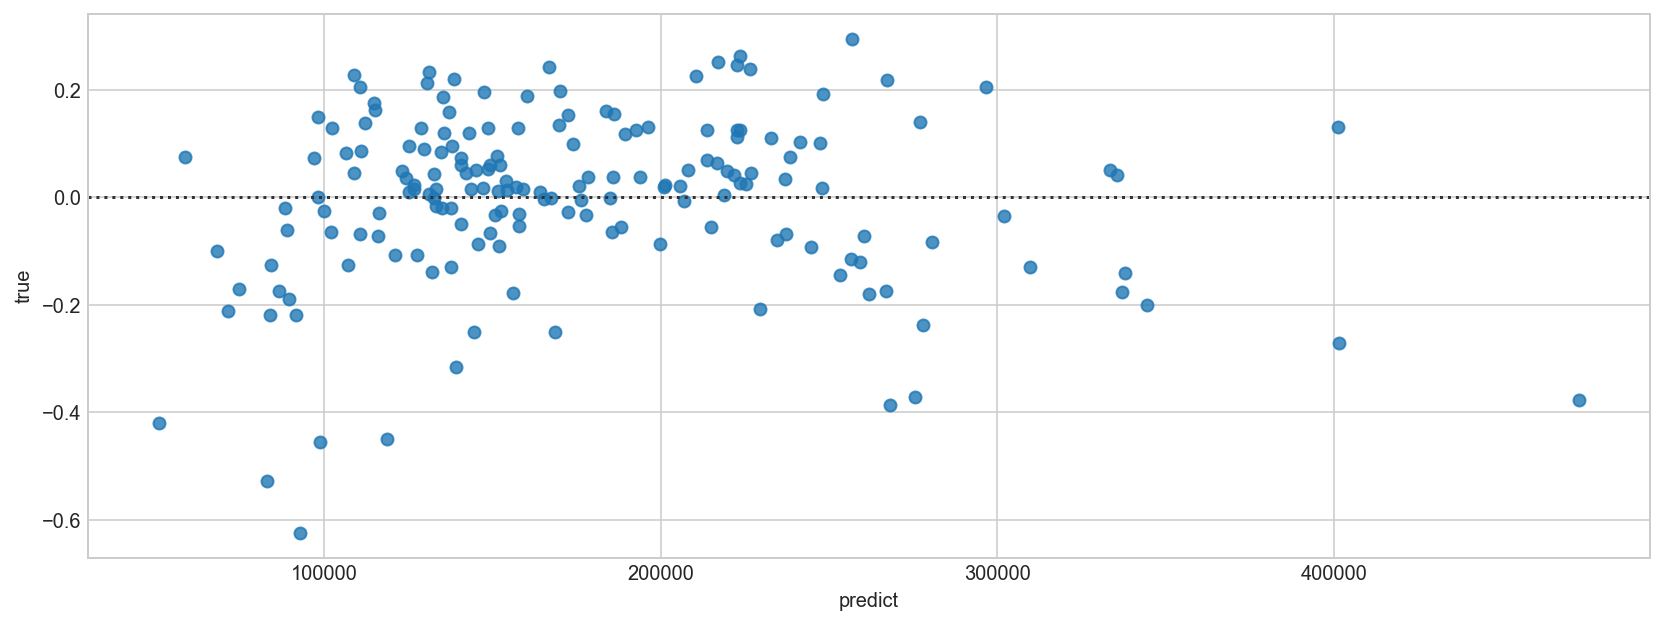

In [37]:
residual_plot = pd.DataFrame(list(zip(y_pred_lasso_log, y_test_log)), columns=['predict','true'])
plt.figure(figsize=(14,5))
sns.residplot(x='predict', y='true', data=residual_plot)

#### 1.14 Identify top features of the housing dataset
---

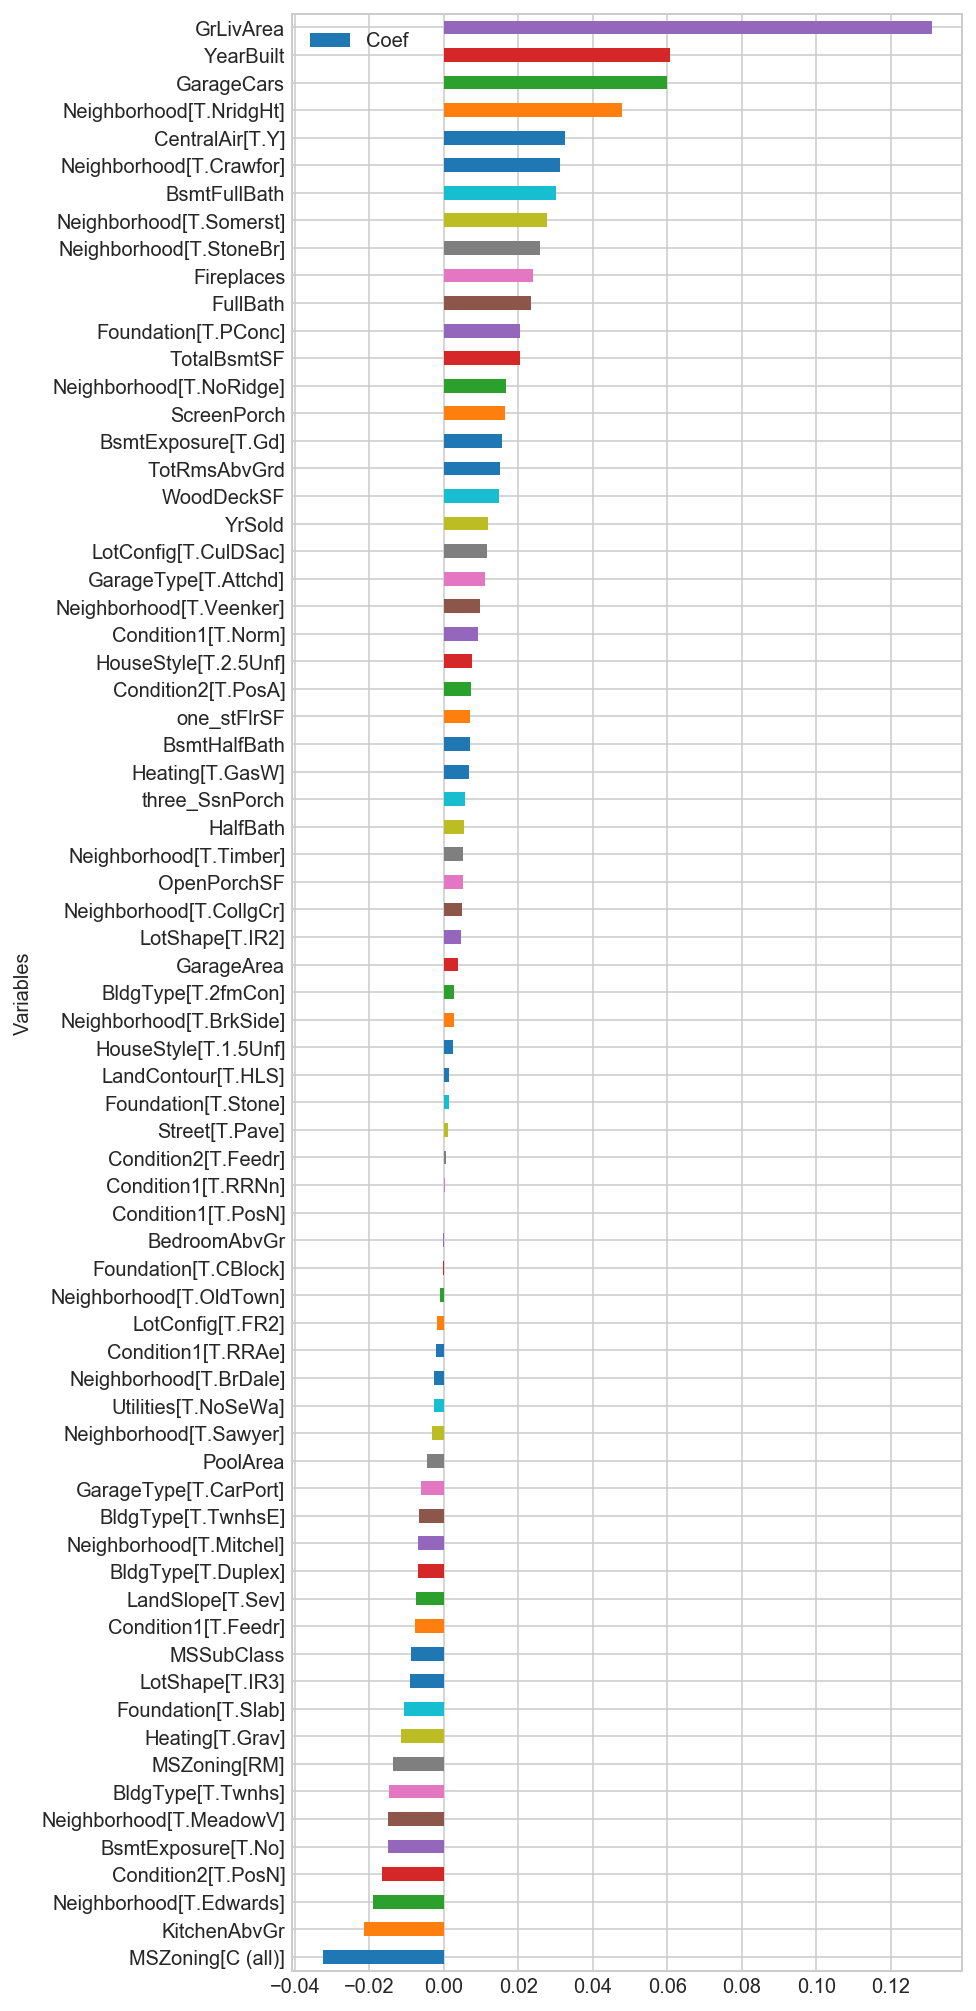

In [38]:
lasso_coefs = pd.DataFrame(list(zip(X_log.columns, coefs_log)), columns=['Variables','Coef'])
lasso_coefs = lasso_coefs.loc[(lasso_coefs['Coef'] != 0)]
lasso_coefs.sort_values('Coef', ascending=True).plot(x='Variables',y='Coef',figsize=(6,18), kind='barh')

In [39]:
lasso_coefs['Coef_abs'] = lasso_coefs['Coef'].abs()
lasso_coefs['Coef_true'] = lasso_coefs['Coef'].map(lambda x: exp(x**2))
lasso_coefs.sort_values('Coef_abs', ascending=False).head(10)

,Variables,Coef,Coef_abs,Coef_true
95,GrLivArea,0.130983,0.130983,1.017305
91,YearBuilt,0.060790,0.060790,1.003702
105,GarageCars,0.059840,0.059840,1.003587
34,Neighborhood[T.NridgHt],0.047916,0.047916,1.002299
82,CentralAir[T.Y],0.032553,0.032553,1.001060
0,MSZoning[C (all)],-0.032476,0.032476,1.001055
24,Neighborhood[T.Crawfor],0.031324,0.031324,1.000982
96,BsmtFullBath,0.030189,0.030189,1.000912
39,Neighborhood[T.Somerst],0.027759,0.027759,1.000771
40,Neighborhood[T.StoneBr],0.025956,0.025956,1.000674


__Top estimators of price__
- GrLivArea: Above grade (ground) living area square feet
- GarageCars: Size of garage in car capacity
- YearBuilt: Original construction date
- Neighbourhood: NridgHt

<a href="https://imgur.com/oUz4xal"><img src="https://i.imgur.com/oUz4xal.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px" title="source: imgur.com" /></a>
## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

#### 2.1 Evaluate residual in the fixed variable model
---

In [40]:
residual_plot['predict_value'] = residual_plot['predict'].map(log)
residual_plot['true_value'] = residual_plot['true'].map(exp)
residual_plot['residual'] = abs(residual_plot['true_value'] - residual_plot['predict'])
residual_plot.head()

,predict,true,predict_value,true_value,residual
0,153968.943858,11.911702,11.944506,149000.0,4968.943858
1,151241.501279,11.944708,11.926633,154000.0,2758.498721
2,132550.282833,11.811547,11.794717,134800.0,2249.717167
3,301865.495610,12.631340,12.617737,306000.0,4134.504390
4,175591.208878,12.016726,12.075914,165500.0,10091.208878


In [41]:
fixed_var_residual_mean = residual_plot['residual'].mean()
fixed_var_residual_median = residual_plot['residual'].median()

In [42]:
# after sorting, we see that the greatest difference goes up to 18.6k!
residual_plot.sort_values('residual', ascending=False).head(10)

,predict,true,predict_value,true_value,residual
111,401369.988970,13.323927,12.902639,611657.0,210287.011030
9,267974.441612,12.100712,12.498647,180000.0,87974.441612
157,275614.504709,12.154779,12.526758,190000.0,85614.504709
147,296724.420258,12.843971,12.600559,378500.0,81775.579742
155,256726.473750,12.721886,12.455766,335000.0,78273.526250
94,472883.944257,13.195614,13.066605,538000.0,65116.055743
55,333476.387722,12.885202,12.717327,394432.0,60955.612278
127,267333.678918,12.700769,12.496253,328000.0,60666.321082
120,335672.669978,12.887127,12.723892,395192.0,59519.330022
27,277972.802795,12.301383,12.535279,220000.0,57972.802795


In [43]:
residual_plot['residual'].describe()

count       175.000000
mean      19578.169117
std       22733.579501
min          18.966037
25%        5978.414157
50%       12536.703886
75%       25344.490982
max      210287.011030
Name: residual, dtype: float64

#### 2.2 EDA for model with changeable features
---

In [44]:
house.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'one_stFlrSF', 'two_ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF', 'OpenPo

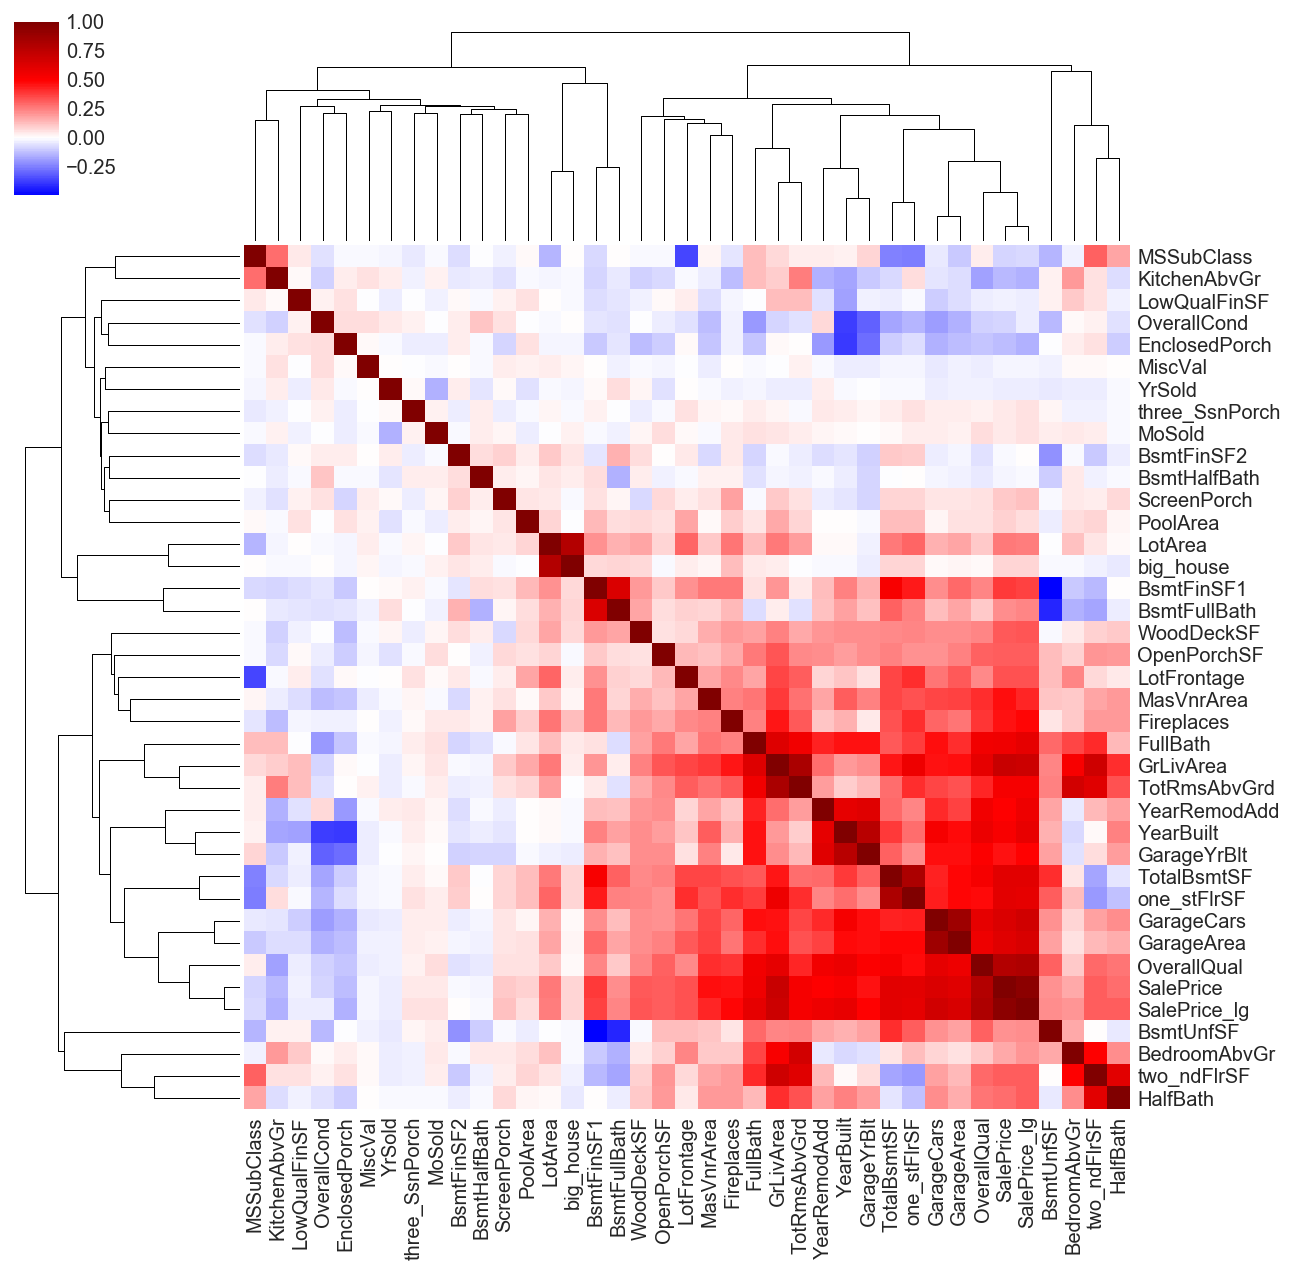

In [45]:
plt.figure(figsize=(12,12))
sns.clustermap(house.corr(), cmap='seismic', center=0)

In [46]:
abs(house.corr()['SalePrice']).sort_values(ascending=False).head(10)

SalePrice       1.000000
SalePrice_lg    0.948374
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
one_stFlrSF     0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
Name: SalePrice, dtype: float64

#### 2.3 Evaluate residual
---

In [47]:
# find out the difference in predicted and actual values
residual_plot['predict_value'] = residual_plot['predict'].map(lambda x:log(x))
residual_plot['true_value'] = residual_plot['true'].map(lambda x: exp(x))
residual_plot['residual'] = abs(residual_plot['true_value'] - residual_plot['predict'])
residual_plot.head()

,predict,true,predict_value,true_value,residual
0,153968.943858,11.911702,11.944506,149000.0,4968.943858
1,151241.501279,11.944708,11.926633,154000.0,2758.498721
2,132550.282833,11.811547,11.794717,134800.0,2249.717167
3,301865.495610,12.631340,12.617737,306000.0,4134.504390
4,175591.208878,12.016726,12.075914,165500.0,10091.208878


In [48]:
# after sorting, we see that the greatest difference goes up to 18.6k!
residual_plot.sort_values('residual', ascending=False).head(10)

,predict,true,predict_value,true_value,residual
111,401369.988970,13.323927,12.902639,611657.0,210287.011030
9,267974.441612,12.100712,12.498647,180000.0,87974.441612
157,275614.504709,12.154779,12.526758,190000.0,85614.504709
147,296724.420258,12.843971,12.600559,378500.0,81775.579742
155,256726.473750,12.721886,12.455766,335000.0,78273.526250
94,472883.944257,13.195614,13.066605,538000.0,65116.055743
55,333476.387722,12.885202,12.717327,394432.0,60955.612278
127,267333.678918,12.700769,12.496253,328000.0,60666.321082
120,335672.669978,12.887127,12.723892,395192.0,59519.330022
27,277972.802795,12.301383,12.535279,220000.0,57972.802795


In [49]:
#append the columns with all with the log function
house['SalePrice_lg'] = house['SalePrice'].map(log)
house_all = [house, house['SalePrice_lg'] ]
all_var = pd.concat(house_all)
all_var_new = all_var.columns.drop([0])

/Users/hayatibintehamzah/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/api.py:87: RuntimeWarning: '<' not supported between instances of 'str' and 'int', sort order is undefined for incomparable objects
  result = result.union(other)


In [50]:
#Evaluate the score of the 'SalePrice_lg with ALL the features
# create X, y
f = 'SalePrice_lg ~ ' +  ' + '.join([c for c in all_var_new])+' - 1'.format()

In [52]:
y_all, X_log_all = patsy.dmatrices(f, data=all_var, return_type='dataframe')

# create train (before 2010) test (2010) split
X_train_log_all = X_log_all[X_log_all['YrSold'] != 2010].drop(['SalePrice_lg','YrSold'],axis=1)
y_train_log_all = X_log_all[X_log_all['YrSold'] != 2010]['SalePrice_lg']

X_test_log_all = X_log_all[X_log_all['YrSold'] == 2010].drop(['SalePrice_lg','YrSold'],axis=1)
y_test_log_all = X_log_all[X_log_all['YrSold'] == 2010]['SalePrice_lg']


# scale
ss = StandardScaler()
ss.fit(X_train_log_all)
Xs_train_log_all = ss.transform(X_train_log_all)
Xs_test_log_all = ss.transform(X_test_log_all)


# fit and score
model_lasso_log_all = LassoCV(cv=10)
model_lasso_log_all.fit(Xs_train_log_all, y_train_log_all)
score_log_all = model_lasso_log_all.score(Xs_test_log_all, y_test_log_all)
y_pred_lasso_log_all = model_lasso_log_all.predict(Xs_test_log_all)
coefs_log_all = model_lasso_log_all.coef_
print(score_log_all)

0.9610537276873103


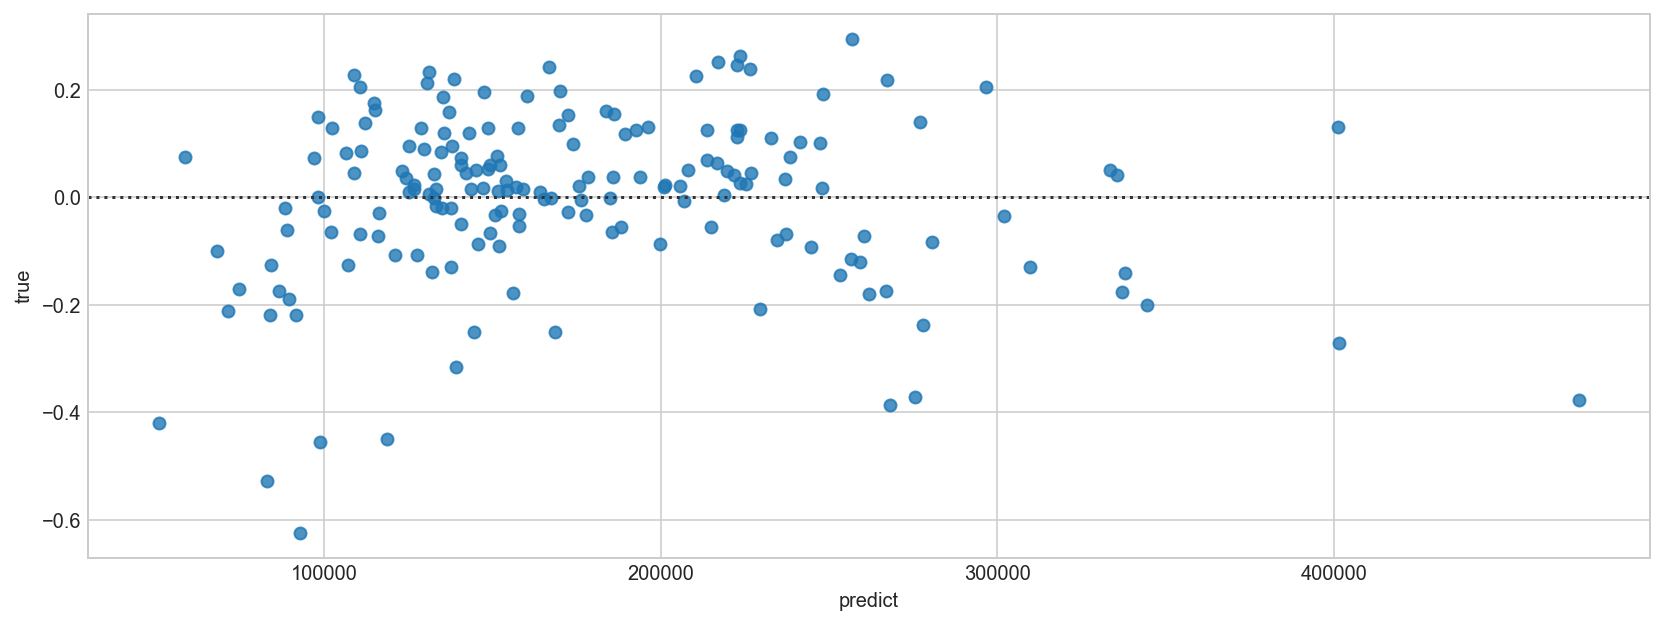

In [53]:
residual_plot_all = pd.DataFrame(list(zip(y_pred_lasso_log_all, y_test_log_all)), columns=['predict','true'])
plt.figure(figsize=(14,5))
sns.residplot(x='predict', y='true', data=residual_plot)

In [54]:
residual_plot_all['residual'] = abs(residual_plot_all['true'] - residual_plot_all['predict'])
residual_plot.head()

,predict,true,predict_value,true_value,residual
0,153968.943858,11.911702,11.944506,149000.0,4968.943858
1,151241.501279,11.944708,11.926633,154000.0,2758.498721
2,132550.282833,11.811547,11.794717,134800.0,2249.717167
3,301865.495610,12.631340,12.617737,306000.0,4134.504390
4,175591.208878,12.016726,12.075914,165500.0,10091.208878


In [55]:
all_var_residual_mean = residual_plot_all['residual'].mean()
all_var_residual_median = residual_plot_all['residual'].median()

In [56]:
residual_plot_all['residual'].describe()

count    175.000000
mean       0.054052
std        0.059223
min        0.000303
25%        0.016689
50%        0.036289
75%        0.064983
max        0.331339
Name: residual, dtype: float64

In [58]:
print('mean diff:')  
print(fixed_var_residual_mean -  all_var_residual_mean)
print('median diff:')
print(fixed_var_residual_median - all_var_residual_median)

mean diff:
19578.115064632624
median diff:
12536.667597680169


<a href="https://imgur.com/oUz4xal"><img src="https://i.imgur.com/oUz4xal.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px" title="source: imgur.com" /></a>

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

#### 3.1 Train-Test-Split
---

In [59]:
f = 'SaleCondition + YrSold ~ '+' + '.join([c for c in house.columns if c != 'SaleCondition'])+' - 1'
f

'SaleCondition + YrSold ~ MSSubClass + MSZoning + LotFrontage + LotArea + Street + LotShape + LandContour + Utilities + LotConfig + LandSlope + Neighborhood + Condition1 + Condition2 + BldgType + HouseStyle + OverallQual + OverallCond + YearBuilt + YearRemodAdd + RoofStyle + RoofMatl + Exterior1st + Exterior2nd + MasVnrType + MasVnrArea + ExterQual + ExterCond + Foundation + BsmtQual + BsmtCond + BsmtExposure + BsmtFinType1 + BsmtFinSF1 + BsmtFinType2 + BsmtFinSF2 + BsmtUnfSF + TotalBsmtSF + Heating + HeatingQC + CentralAir + Electrical + one_stFlrSF + two_ndFlrSF + LowQualFinSF + GrLivArea + BsmtFullBath + BsmtHalfBath + FullBath + HalfBath + BedroomAbvGr + KitchenAbvGr + KitchenQual + TotRmsAbvGrd + Functional + Fireplaces + GarageType + GarageYrBlt + GarageFinish + GarageCars + GarageArea + GarageQual + GarageCond + PavedDrive + WoodDeckSF + OpenPorchSF + EnclosedPorch + three_SsnPorch + ScreenPorch + PoolArea + MiscVal + MoSold + YrSold + SaleType + SalePrice + big_house + SalePric

In [60]:
y, X = patsy.dmatrices(f, data=house, return_type='dataframe')

In [61]:
# create train test split
X_train = X[X['YrSold'] != 2010].drop(['YrSold'],axis=1)
y_train = y[y['YrSold'] != 2010]['SaleCondition[Abnorml]']

X_test = X[X['YrSold'] == 2010].drop(['YrSold'],axis=1)
y_test = y[y['YrSold'] == 2010]['SaleCondition[Abnorml]']

In [62]:
# scale
ss = StandardScaler()
ss.fit(X_train)
Xs_train = ss.transform(X_train)
Xs_test = ss.transform(X_test)

#### 3.2 Revise datasets by doing undersampling/oversampling/SMOTE/SMOTEENN
---

In [63]:
# undersampling

from imblearn.under_sampling import ClusterCentroids
cc = ClusterCentroids(random_state=0)
X_resampled_under, y_resampled_under = cc.fit_sample(Xs_train, y_train)

# oversampling

from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled_over, y_resampled_over = ros.fit_sample(Xs_train, y_train)

# SMOTE

from imblearn.over_sampling import SMOTE
X_resampled_smote, y_resampled_smote = SMOTE().fit_sample(Xs_train, y_train)

# SMOTEENN

from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=0)
X_resampled_smoteenn, y_resampled_smoteenn = smote_enn.fit_sample(Xs_train, y_train)

#### 3.3 Logistic Regression with cross validation

In [64]:
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score, make_scorer

# empty list to hold all model scores
overall_scores = []

# make precision scorer
scorer = make_scorer(f1_score)

/Users/hayatibintehamzah/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [66]:
from sklearn.linear_model import LogisticRegressionCV

def model_lg(technique, X_resampled, y_resampled, Xs_test, y_test):

    # define model and fit
    lg = LogisticRegressionCV(Cs=50, cv=5, scoring=scorer, penalty='l2')
    lg.fit(X_resampled, y_resampled)
    
    # obtain mean of cross validation precision scores
    avg_score = np.mean(list(lg.scores_.values()))
    
    # obtain cross validation predictions to make classification report and confusion matrix
    y_pred_lg = lg.predict(Xs_test)

    # find coefs
    coefs = pd.DataFrame(list(zip(X_train.columns, lg.coef_[0])), columns=['Variable','Coef'])
    coefs = coefs.loc[(coefs['Coef'] != 0)]
    coefs['Coef_abs'] = coefs['Coef'].abs()
    top_3_coefs = coefs.sort_values('Coef_abs', ascending=False).head(3)
    
    # print scores    
    print(technique) 
    print("-------------------------------------------------------------")

    print(metrics.classification_report(y_test, y_pred_lg))

    print(metrics.confusion_matrix(y_test, y_pred_lg))

    print("Average f-1 score from CV:" )
    print(avg_score)

    print("top 3 coefficients: " )
    print(top_3_coefs)



    
    # append to overall scores
    overall_scores.append((avg_score, "Logistic Regression - ", technique))
    print('-----------------------------------------------------------------')


In [67]:
model_lg('undersampling', X_resampled_under, y_resampled_under, Xs_test, y_test)
model_lg('oversampling', X_resampled_over, y_resampled_over, Xs_test, y_test)
model_lg('SMOTE', X_resampled_smote, y_resampled_smote, Xs_test, y_test)
model_lg('SMOTEENN', X_resampled_smoteenn, y_resampled_smoteenn, Xs_test, y_test)

undersampling
-------------------------------------------------------------
             precision    recall  f1-score   support

        0.0       1.00      0.40      0.57       164
        1.0       0.10      1.00      0.18        11

avg / total       0.94      0.44      0.55       175

[[66 98]
 [ 0 11]]
Average f-1 score from CV:
0.5118860339070415
top 3 coefficients: 
            Variable      Coef  Coef_abs
190  SaleType[T.Oth]  0.002958  0.002958
144  Heating[T.GasA]  0.002770  0.002770
194          LotArea -0.002634  0.002634
-----------------------------------------------------------------
oversampling
-------------------------------------------------------------
             precision    recall  f1-score   support

        0.0       0.95      0.86      0.90       164
        1.0       0.12      0.27      0.16        11

avg / total       0.89      0.82      0.85       175

[[141  23]
 [  8   3]]
Average f-1 score from CV:
0.8793876680774424
top 3 coefficients: 
             

#### 3.3 Try decision tree classifier
---

In [68]:
from sklearn.tree import DecisionTreeClassifier

def model_tree(technique, X_resampled, y_resampled, Xs_test, y_test):
    # run cross validation
    tree = DecisionTreeClassifier()
    scores = cross_val_score(tree, X_resampled, y_resampled, cv=5, scoring=scorer)
    
    # obtain avg cross validated precision score
    avg_score = scores.mean()

    # run tree for predictions to make classification report and confusion matrix
    tree.fit(X_resampled, y_resampled)
    y_pred_tree = tree.predict(Xs_test)
    
    # print scores
    print(technique)
    print('-------------------------------------------------------------')

    print(metrics.classification_report(y_test, y_pred_tree))

    print(metrics.confusion_matrix(y_test, y_pred_tree))

    print('average f-1 score from CV: ')
    print(avg_score)

    
    # append to overall scores
    overall_scores.append((avg_score, 'Decision Tree - ',technique))
    
model_tree('undersampling', X_resampled_under, y_resampled_under, Xs_test, y_test)
model_tree('oversampling', X_resampled_over, y_resampled_over, Xs_test, y_test)
model_tree('SMOTE', X_resampled_smote, y_resampled_smote, Xs_test, y_test)
model_tree('SMOTEENN', X_resampled_smoteenn, y_resampled_smoteenn, Xs_test, y_test)

undersampling
-------------------------------------------------------------
             precision    recall  f1-score   support

        0.0       1.00      0.21      0.34       164
        1.0       0.08      1.00      0.14        11

avg / total       0.94      0.26      0.33       175

[[ 34 130]
 [  0  11]]
average f-1 score from CV: 
0.7654700854700854
oversampling
-------------------------------------------------------------
             precision    recall  f1-score   support

        0.0       0.95      0.95      0.95       164
        1.0       0.20      0.18      0.19        11

avg / total       0.90      0.90      0.90       175

[[156   8]
 [  9   2]]
average f-1 score from CV: 
0.9583570927579039
SMOTE
-------------------------------------------------------------
             precision    recall  f1-score   support

        0.0       0.94      0.92      0.93       164
        1.0       0.07      0.09      0.08        11

avg / total       0.88      0.87      0.88       1

#### 3.4 Try KNN

In [69]:
from sklearn.neighbors import KNeighborsClassifier


def model_knn(technique, X_resampled, y_resampled, Xs_test, y_test):
    
    cv_scores = []

    # create list of odd numbers for cross-validation
    neighbors = list(range(1,15,2))

    for k in neighbors:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X_resampled, y_resampled, cv=5, scoring=scorer)
        cv_scores.append((scores.mean(), k))

    #obtain best k and best mean cv f-beta score
    best_k = max(cv_scores)[1]
    avg_score = max(cv_scores)[0]

    # run KNN on best_k for predictions to make classification report and confusion matrix
    knn = KNeighborsClassifier(n_neighbors=best_k)
    knn.fit(X_resampled, y_resampled)
    y_pred_knn = knn.predict(Xs_test)
    
    # print scores
    print(technique)
    print('n_neighbours =') 
    print(best_k)
    print('-------------------------------------------------------------')
    print(metrics.classification_report(y_test, y_pred_knn))

    print(metrics.confusion_matrix(y_test, y_pred_knn))

    print('average f-1 score from CV:')
    print(avg_score)


    
    # append to overall scores
    overall_scores.append((avg_score, "KNN -", technique))
    return avg_score
    
model_knn('undersampling', X_resampled_under, y_resampled_under, Xs_test, y_test)
model_knn('oversampling', X_resampled_over, y_resampled_over, Xs_test, y_test)
model_knn('SMOTE', X_resampled_smote, y_resampled_smote, Xs_test, y_test)
model_knn('SMOTEENN', X_resampled_smoteenn, y_resampled_smoteenn, Xs_test, y_test)

/Users/hayatibintehamzah/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/hayatibintehamzah/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/hayatibintehamzah/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/hayatibintehamzah/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pre

undersampling
n_neighbours =
1
-------------------------------------------------------------
             precision    recall  f1-score   support

        0.0       0.95      0.88      0.92       164
        1.0       0.17      0.36      0.24        11

avg / total       0.90      0.85      0.87       175

[[145  19]
 [  7   4]]
average f-1 score from CV:
0.2628985507246377
oversampling
n_neighbours =
1
-------------------------------------------------------------
             precision    recall  f1-score   support

        0.0       0.95      0.92      0.93       164
        1.0       0.19      0.27      0.22        11

avg / total       0.90      0.88      0.89       175

[[151  13]
 [  8   3]]
average f-1 score from CV:
0.9541175022628945
SMOTE
n_neighbours =
1
-------------------------------------------------------------
             precision    recall  f1-score   support

        0.0       0.94      0.79      0.86       164
        1.0       0.08      0.27      0.12        11

a

0.9807279567701113

In [70]:
list(reversed(sorted(overall_scores)))

[(0.9807279567701113, 'KNN -', 'SMOTEENN'),
 (0.9583570927579039, 'Decision Tree - ', 'oversampling'),
 (0.9541175022628945, 'KNN -', 'oversampling'),
 (0.9382978528695868, 'Logistic Regression - ', 'SMOTEENN'),
 (0.9338618029830025, 'Decision Tree - ', 'SMOTEENN'),
 (0.9281815909722964, 'Decision Tree - ', 'SMOTE'),
 (0.9033518216530035, 'KNN -', 'SMOTE'),
 (0.8793876680774424, 'Logistic Regression - ', 'oversampling'),
 (0.8769788528485988, 'Logistic Regression - ', 'SMOTE'),
 (0.7654700854700854, 'Decision Tree - ', 'undersampling'),
 (0.5118860339070415, 'Logistic Regression - ', 'undersampling'),
 (0.2628985507246377, 'KNN -', 'undersampling')]

__KNN with SMOTEENN gives the highest f-1 score, followed by Decision Tree and KNN with oversampling.__ 

Logistic Regression with SMOTEENN gives the below top predictors.
To test the importance of these predictors, we need to run KNN with SMOTEENN without them and assess the impact on the model performance.

In [71]:
# drop columns

impact_on_score = []

original_score = model_knn('SMOTEENN', X_resampled_smoteenn, y_resampled_smoteenn, Xs_test, y_test)    

SMOTEENN
n_neighbours =
1
-------------------------------------------------------------
             precision    recall  f1-score   support

        0.0       0.96      0.57      0.71       164
        1.0       0.09      0.64      0.16        11

avg / total       0.90      0.57      0.68       175

[[93 71]
 [ 4  7]]
average f-1 score from CV:
0.9807279567701113


In [73]:
def drop_col(col):

    X_train_drop_col = X_train.drop(col, axis=1)
    X_test_drop_col = X_test.drop(col, axis=1)

    # scale
    ss = StandardScaler()
    ss.fit(X_train_drop_col)
    Xs_train_drop_col = ss.transform(X_train_drop_col)
    Xs_test_drop_col = ss.transform(X_test_drop_col)

    # resample SMOTEENN
    X_resampled_smoteenn_drop_col, y_resampled_smoteenn_drop_col = smote_enn.fit_sample(
        Xs_train_drop_col, y_train)

    # run model
    print(col , 'dropped')
    
    print('------------')
    
    new_score = model_knn('SMOTEENN', X_resampled_smoteenn_drop_col, 
                          y_resampled_smoteenn_drop_col, Xs_test_drop_col, y_test)
    
    impact = original_score - new_score
    impact_on_score.append((impact, col))

In [74]:
for col in list(X_train.columns):
    drop_col(col)

MSZoning[C (all)] dropped
------------
SMOTEENN
n_neighbours =
1
-------------------------------------------------------------
             precision    recall  f1-score   support

        0.0       0.94      0.57      0.71       164
        1.0       0.07      0.45      0.12        11

avg / total       0.89      0.57      0.67       175

[[94 70]
 [ 6  5]]
average f-1 score from CV:
0.9811269384486723
MSZoning[FV] dropped
------------
SMOTEENN
n_neighbours =
1
-------------------------------------------------------------
             precision    recall  f1-score   support

        0.0       0.96      0.57      0.71       164
        1.0       0.09      0.64      0.16        11

avg / total       0.90      0.57      0.68       175

[[93 71]
 [ 4  7]]
average f-1 score from CV:
0.9807279567701113
MSZoning[RH] dropped
------------
SMOTEENN
n_neighbours =
1
-------------------------------------------------------------
             precision    recall  f1-score   support

        0.0    

Neighborhood[T.BrkSide] dropped
------------
SMOTEENN
n_neighbours =
1
-------------------------------------------------------------
             precision    recall  f1-score   support

        0.0       0.96      0.57      0.72       164
        1.0       0.09      0.64      0.16        11

avg / total       0.90      0.58      0.68       175

[[94 70]
 [ 4  7]]
average f-1 score from CV:
0.9787081843046497
Neighborhood[T.ClearCr] dropped
------------
SMOTEENN
n_neighbours =
1
-------------------------------------------------------------
             precision    recall  f1-score   support

        0.0       0.96      0.57      0.71       164
        1.0       0.09      0.64      0.16        11

avg / total       0.90      0.57      0.68       175

[[93 71]
 [ 4  7]]
average f-1 score from CV:
0.9807163139716577
Neighborhood[T.CollgCr] dropped
------------
SMOTEENN
n_neighbours =
1
-------------------------------------------------------------
             precision    recall  f1-scor

Neighborhood[T.Timber] dropped
------------
SMOTEENN
n_neighbours =
1
-------------------------------------------------------------
             precision    recall  f1-score   support

        0.0       0.95      0.59      0.72       164
        1.0       0.08      0.55      0.14        11

avg / total       0.90      0.58      0.69       175

[[96 68]
 [ 5  6]]
average f-1 score from CV:
0.9835354798179541
Neighborhood[T.Veenker] dropped
------------
SMOTEENN
n_neighbours =
1
-------------------------------------------------------------
             precision    recall  f1-score   support

        0.0       0.96      0.57      0.71       164
        1.0       0.09      0.64      0.16        11

avg / total       0.90      0.57      0.68       175

[[93 71]
 [ 4  7]]
average f-1 score from CV:
0.980315697122283
Condition1[T.Feedr] dropped
------------
SMOTEENN
n_neighbours =
1
-------------------------------------------------------------
             precision    recall  f1-score   su

SMOTEENN
n_neighbours =
1
-------------------------------------------------------------
             precision    recall  f1-score   support

        0.0       0.96      0.57      0.71       164
        1.0       0.09      0.64      0.16        11

avg / total       0.90      0.57      0.68       175

[[93 71]
 [ 4  7]]
average f-1 score from CV:
0.9811302188632206
HouseStyle[T.1.5Unf] dropped
------------
SMOTEENN
n_neighbours =
1
-------------------------------------------------------------
             precision    recall  f1-score   support

        0.0       0.96      0.57      0.71       164
        1.0       0.09      0.64      0.16        11

avg / total       0.90      0.57      0.68       175

[[93 71]
 [ 4  7]]
average f-1 score from CV:
0.9795277413928009
HouseStyle[T.1Story] dropped
------------
SMOTEENN
n_neighbours =
1
-------------------------------------------------------------
             precision    recall  f1-score   support

        0.0       0.96      0.59      

Exterior1st[T.BrkComm] dropped
------------
SMOTEENN
n_neighbours =
1
-------------------------------------------------------------
             precision    recall  f1-score   support

        0.0       0.96      0.56      0.71       164
        1.0       0.09      0.64      0.16        11

avg / total       0.90      0.57      0.67       175

[[92 72]
 [ 4  7]]
average f-1 score from CV:
0.9811402921824467
Exterior1st[T.BrkFace] dropped
------------
SMOTEENN
n_neighbours =
1
-------------------------------------------------------------
             precision    recall  f1-score   support

        0.0       0.96      0.57      0.71       164
        1.0       0.09      0.64      0.16        11

avg / total       0.90      0.57      0.68       175

[[93 71]
 [ 4  7]]
average f-1 score from CV:
0.9815292005417817
Exterior1st[T.CBlock] dropped
------------
SMOTEENN
n_neighbours =
1
-------------------------------------------------------------
             precision    recall  f1-score   

Exterior2nd[T.MetalSd] dropped
------------
SMOTEENN
n_neighbours =
1
-------------------------------------------------------------
             precision    recall  f1-score   support

        0.0       0.95      0.57      0.71       164
        1.0       0.08      0.55      0.14        11

avg / total       0.89      0.57      0.67       175

[[93 71]
 [ 5  6]]
average f-1 score from CV:
0.9843666684472622
Exterior2nd[T.Other] dropped
------------
SMOTEENN
n_neighbours =
1
-------------------------------------------------------------
             precision    recall  f1-score   support

        0.0       0.96      0.57      0.71       164
        1.0       0.09      0.64      0.16        11

avg / total       0.90      0.57      0.68       175

[[93 71]
 [ 4  7]]
average f-1 score from CV:
0.9807279567701113
Exterior2nd[T.Plywood] dropped
------------
SMOTEENN
n_neighbours =
1
-------------------------------------------------------------
             precision    recall  f1-score   s

SMOTEENN
n_neighbours =
1
-------------------------------------------------------------
             precision    recall  f1-score   support

        0.0       0.96      0.57      0.71       164
        1.0       0.09      0.64      0.16        11

avg / total       0.90      0.57      0.68       175

[[93 71]
 [ 4  7]]
average f-1 score from CV:
0.9799267230713617
Foundation[T.Stone] dropped
------------
SMOTEENN
n_neighbours =
1
-------------------------------------------------------------
             precision    recall  f1-score   support

        0.0       0.96      0.57      0.71       164
        1.0       0.09      0.64      0.16        11

avg / total       0.90      0.57      0.68       175

[[93 71]
 [ 4  7]]
average f-1 score from CV:
0.9803273399207365
Foundation[T.Wood] dropped
------------
SMOTEENN
n_neighbours =
1
-------------------------------------------------------------
             precision    recall  f1-score   support

        0.0       0.96      0.56      0.7

BsmtFinType2[T.Unf] dropped
------------
SMOTEENN
n_neighbours =
1
-------------------------------------------------------------
             precision    recall  f1-score   support

        0.0       0.97      0.57      0.72       164
        1.0       0.10      0.73      0.18        11

avg / total       0.91      0.58      0.68       175

[[93 71]
 [ 3  8]]
average f-1 score from CV:
0.9823486238266085
Heating[T.GasA] dropped
------------
SMOTEENN
n_neighbours =
1
-------------------------------------------------------------
             precision    recall  f1-score   support

        0.0       0.96      0.57      0.71       164
        1.0       0.09      0.64      0.16        11

avg / total       0.90      0.57      0.68       175

[[93 71]
 [ 4  7]]
average f-1 score from CV:
0.9803273399207365
Heating[T.GasW] dropped
------------
SMOTEENN
n_neighbours =
1
-------------------------------------------------------------
             precision    recall  f1-score   support

       

KeyboardInterrupt: 

In [75]:
impact_on_score

[(-0.00039898167856100564, 'MSZoning[C (all)]'),
 (0.0, 'MSZoning[FV]'),
 (-0.00040556273640424134, 'MSZoning[RH]'),
 (-8.206237796626326e-06, 'MSZoning[RL]'),
 (-0.0004121641896576156, 'MSZoning[RM]'),
 (0.0, 'Street[T.Pave]'),
 (-0.0008061795857789988, 'LotShape[T.IR2]'),
 (-1.6452437345826354e-06, 'LotShape[T.IR3]'),
 (0.00034453798323452745, 'LotShape[T.Reg]'),
 (-0.0004123354123354295, 'LandContour[T.HLS]'),
 (0.0, 'LandContour[T.Low]'),
 (0.00039571125487292136, 'LandContour[T.Lvl]'),
 (0.0, 'Utilities[T.NoSeWa]'),
 (-0.0012335601632731397, 'LotConfig[T.CulDSac]'),
 (-1.6452437345826354e-06, 'LotConfig[T.FR2]'),
 (-0.00040226209310934014, 'LotConfig[T.FR3]'),
 (-0.002430106993043246, 'LotConfig[T.Inside]'),
 (-0.00204289836352034, 'LandSlope[T.Mod]'),
 (8.36238390500288e-06, 'LandSlope[T.Sev]'),
 (0.0, 'Neighborhood[T.Blueste]'),
 (0.0007979733479823725, 'Neighborhood[T.BrDale]'),
 (0.002019772465461589, 'Neighborhood[T.BrkSide]'),
 (1.1642798453559422e-05, 'Neighborhood[T.ClearC

In [77]:
impact_list = impact_on_score.copy()

In [78]:
list(reversed(sorted(impact_list)))

[(0.002019772465461589, 'Neighborhood[T.BrkSide]'),
 (0.0020050772128556993, 'MasVnrType[T.BrkFace]'),
 (0.0019949283745255286, 'Exterior2nd[T.VinylSd]'),
 (0.0019949283745255286, 'Exterior1st[T.VinylSd]'),
 (0.0019900326896575837, 'ExterCond[T.TA]'),
 (0.0016158767498833937, 'HeatingQC[T.Fa]'),
 (0.0016147236728205616, 'Neighborhood[T.Gilbert]'),
 (0.0015943314256450236, 'KitchenQual[T.Fa]'),
 (0.0015926962548313828, 'Neighborhood[T.Crawfor]'),
 (0.0015881763872656052, 'Neighborhood[T.Mitchel]'),
 (0.0012201654950104723, 'Neighborhood[T.NoRidge]'),
 (0.0012002153773104096, 'HouseStyle[T.1.5Unf]'),
 (0.0012002153773104096, 'BsmtQual[T.Fa]'),
 (0.0008146430511338787, 'BsmtCond[T.TA]'),
 (0.0008114390929722104, 'BsmtCond[T.Gd]'),
 (0.0008063357318874864, 'Exterior2nd[T.Stucco]'),
 (0.0008013999177789444, 'Neighborhood[T.OldTown]'),
 (0.0008013999177789444, 'BsmtFinType1[T.Unf]'),
 (0.000801233698749515, 'Foundation[T.Slab]'),
 (0.000801233698749515, 'Exterior1st[T.Stucco]'),
 (0.00079797

- [(0.0044766157707263332, 'GarageFinish[T.RFn]')

- (0.0044717006085596145, 'Neighborhood[T.NAmes]')

- (0.0040776544953117222, 'MasVnrType[T.BrkFace]')

GarageFinish (Rough Finished), Neighbourhood (North Ames) and MasVnrType (BrickFace) have the greatest impact on predicting whether the sale will be Abnorml.